# SAGACITE (Statistical and Geometric Analysis of CITE-seq)

In [1]:
import os
import re
import time
# import gzip
# import h5py
import numpy as np
import scipy.io
import scipy.sparse
import scipy.stats
import scipy.special
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
import seaborn as sns

## geom

def norm(v):
    v = np.array(v)
    normv = np.sqrt( np.sum(v**2) )
    return normv

def psi(data):
    sdata = 2* np.sqrt(data)
    return sdata

def ExpMap_s(s, w):
    s = np.array(s)
    w = np.array(w)
    r = s * np.cos(norm(w)/2) + 2. * w / norm(w) * np.sin(norm(w)/2)
    return r

def InvExpMap_s(s, r):
    s = np.array(s)
    r = np.array(r)
    costheta = 0.25 * np.sum(s * r)
    if  1.0 - costheta < 1e-9:
        w = np.zeros(s.shape)
    else:
        w = np.arccos(costheta) / np.sqrt(1. - costheta**2) * (r - s * costheta)
    return w

def RiemannianCoM_s(sdata, epsilon=1e-9, max_iter=100):
    sdata = np.array(sdata)
    (nSample, d) = sdata.shape
    t0 = time.time()
    s_k = 2. * np.ones(d, dtype=float) / np.sqrt(d)
    for k in range(max_iter):
        w = np.zeros(d, dtype=float)
        for i in range(nSample):
            si = sdata[i]
            wi = InvExpMap_s(s_k, si)
            w = w + wi / nSample
        s_k = ExpMap_s(s_k, w)
        if norm(w) < epsilon:
            # print('n_iter = ', k)
            break
    t1 = time.time()
    # print('CoM_time =', t1-t0)
    return s_k

def RotateData_s(sdata, s, r):
    sdata = np.array(sdata)
    sdata = sdata * 0.5
    s = np.array(s)
    r = np.array(r)
    (nSample, d) = sdata.shape
    t0 = time.time()
    a = s * 0.5
    b = r * 0.5
    costheta = a.dot(b)
    theta = np.arccos(costheta)
    sintheta = np.sin(theta)
    b2 = (b - a * costheta) / sintheta
    sa = sdata.dot(a)
    sb2 = sdata.dot(b2)
    sdata = sdata + np.outer( (costheta - 1) * sa - sintheta * sb2, a) + np.outer( sintheta * sa + (costheta - 1) * sb2, b2)
    sdata = sdata * 2.
    t1 = time.time()
    # print('Rotate_time =', t1-t0)
    return sdata


def count2shpere(count_data):
    count_data = np.array(count_data)
    total_count = np.sum(count_data, axis=1)
    prop_data = count_data / total_count[:,None]
    sdata = psi(prop_data)
    return sdata

def count2shpere_CoM(count_data, epsilon=1e-9, max_iter=100):
    count_data = np.array(count_data)
    total_count = np.sum(count_data, axis=1)
    prop_data = count_data / total_count[:,None]
    sdata = psi(prop_data)
    (nSample, d) = sdata.shape
    t0 = time.time()
    s_k = 2. * np.ones(d, dtype=float) / np.sqrt(d)
    for k in range(max_iter):
        w = np.zeros(d, dtype=float)
        for i in range(nSample):
            si = sdata[i]
            wi = InvExpMap_s(s_k, si)
            w = w + wi / nSample
        s_k = ExpMap_s(s_k, w)
        if norm(w) < epsilon:
            # print('n_iter = ', k)
            break
    t1 = time.time()
    # print('CoM_time =', t1-t0)
    return s_k

def count2shpere_CoM_wtd(count_data, epsilon=1e-9, max_iter=100):
    count_data = np.array(count_data)
    total_count = np.sum(count_data, axis=1)
    prop_data = count_data / total_count[:,None]
    sdata = psi(prop_data)
    wt = total_count / np.sum(total_count)
    (nSample, d) = sdata.shape
    t0 = time.time()
    s_k = 2. * np.ones(d, dtype=float) / np.sqrt(d)
    for k in range(max_iter):
        w = np.zeros(d, dtype=float)
        for i in range(nSample):
            si = sdata[i]
            wi = InvExpMap_s(s_k, si)
            w = w + wi * wt[i]
        s_k = ExpMap_s(s_k, w)
        if norm(w) < epsilon:
            # print('n_iter = ', k)
            break
    t1 = time.time()
    # print('CoM_time =', t1-t0)
    return s_k

def sphere2simplex(sdata):
    sdata = np.array(sdata)
    dn = np.array(sdata < 0, dtype=int)
    sodata = (sdata - sdata * dn)**2 / 4.
    r2 = np.sum( sodata, axis=1 )
    data = sodata / r2[:, None]
    return data

## stat

def ml_gamma(e_lam, e_loglam, a):
    inv_a_new = 1/a + (e_loglam.mean() - np.log(e_lam.mean()) + np.log(a) - scipy.special.digamma(a))/(a - a**2*scipy.special.polygamma(1,a) )
    a_new = 1/inv_a_new
    return a_new

def ll_gamma(e_lam, e_loglam, a):
    ll = (a-1)*e_loglam.mean() - np.log(scipy.special.gamma(a)) - a*np.log(e_lam.mean()) + a*np.log(a) - a
    return ll

def m_step(e_lam, e_loglam, max_iter=10, min_iter = 3):
    lis = [0.]
    a = 0.5/( np.log(e_lam.mean()) - e_loglam.mean() )
    ll = ll_gamma(e_lam, e_loglam, a)
    lis.append(ll)
    for i in range(max_iter):
        a = ml_gamma(e_lam, e_loglam, a)
        ll = ll_gamma(e_lam, e_loglam, a)
        lis.append(ll)
        if i > min_iter and -1e-9 < lis[-1] - lis[-2] < 1e-9:
            b = a/e_lam.mean()
            return a, b, ll

def em_nb(y, m, max_iter=300, min_iter=10):
    # initialization
    m_st = scipy.stats.mstats.gmean(m)
    e_lam = np.divide(y+1/m_st, m+1)
    e_loglam = np.log(e_lam)
    lis = [0.]
    (a, b, ll) = m_step(e_lam, e_loglam)
    lis.append(ll)
    for i in range(max_iter):
        # e_step
        e_lam = np.divide( y+a , m+b )
        e_loglam = scipy.special.digamma(y+a) - np.log(m+b)
        (a, b, ll) = m_step(e_lam, e_loglam)
        lis.append(ll)
        if i > min_iter and -1e-9 < lis[-1] - lis[-2] < 1e-9:
            break
#     print( 'n_iter =', i )
    return a, b

def p_nb(y, m, a, b):
    p = scipy.stats.nbinom.pmf(y, a, b/(m+b))
    return p

def lp_nb(y, m, a, b):
    lp = scipy.stats.nbinom.logpmf(y, a, b/(m+b))
    return lp

def pval_nb(y, m, a, b):
    p_geq = 1. - scipy.stats.nbinom.cdf(y-1, a, b/(m+b))
    return p_geq


def f_em(y, m, pzj, max_iter=300, min_iter=10):
    # initialization
    m_st = scipy.stats.mstats.gmean(m)
    e_lam = np.divide(y+1/m_st, m)
    e_loglam = np.log(e_lam)
    fj = pzj.mean()
    k_e_lam = pzj * e_lam / fj
    k_e_loglam = pzj * e_loglam / fj
    lis = [0.]
    (a, b, ll) = m_step(k_e_lam, k_e_loglam)
    lis.append(ll)
    for i in range(max_iter):
        # e_step
        e_lam = np.divide( y+a , m+b )
        e_loglam = scipy.special.digamma(y+a) - np.log(m+b)
        k_e_lam = pzj * e_lam / fj
        k_e_loglam = pzj * e_loglam / fj
        (a, b, ll) = m_step(k_e_lam, k_e_loglam)
        lis.append(ll)
        if i > min_iter and -1e-6 < lis[-1] - lis[-2] < 1e-6:
            break
#     print( 'n_iter =', i)
    return a, b, ll


def em_zinb(y, m, max_iter=300, min_iter=10):
    # initialization
    w0 = 0.02
    (a1, b1) = em_nb(y,m)
    pmf0 = (y==0).astype('int')
    pmf1 = p_nb(y, m, a1, b1)
    ll0 = np.mean( np.log(w0*pmf0 + (1-w0)*pmf1) )
#     print(w0, a1, b1, ll0)
    lis = [ll0]
    for n in range(max_iter):
        pz0 = w0*pmf0/(w0*pmf0 + (1-w0)*pmf1)
        w0 = pz0.mean()
        (a1, b1, ll) = f_em(y, m, 1.-pz0)
        pmf0 = (y==0).astype('int')
        pmf1 = p_nb(y, m, a1, b1)
        ll0 = np.mean( np.log(w0*pmf0 + (1-w0)*pmf1) )
#         print(w0, a1, b1)
        lis.append(ll0)
        if n > min_iter and (-1e-6 < lis[-1] - lis[-2] < 1e-6):
            break
    is_conv = ( n+1 < max_iter )
    return w0, a1, b1, is_conv


def pval_zinb(y, m, w0, a, b):
    y = np.asarray(y, dtype='int')
    m = np.asarray(m)
    p_geq = (1.-w0) * (1.- scipy.stats.nbinom.cdf(y-1, a, b/(m+b)) ) + w0 * np.array(y==0, dtype=float)
    return p_geq


def p_adjust_bh(p):
    """Benjamini-Hochberg p-value correction for multiple hypothesis testing."""
    """https://stackoverflow.com/questions/7450957/how-to-implement-rs-p-adjust-in-python"""
    p = np.asfarray(p)
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(len(p), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    return q[by_orig]


def transf_zinb(y, m, a, b, w0=0., is_log='False', log_base = np.exp(1) ):
    y = np.asarray(y, dtype='int')
    dy0 = (y==0).astype('int')
    m = np.asarray(m)
    e_lam = (1. - np.divide( w0 * dy0, ( w0 + (1-w0) * np.divide( b, m+b )**a ) ) ) * np.divide( y+a , m+b )
    if is_log=='False':
        print('a =', a, ', b =', b, ', w =', w0, ', log:', is_log)
        return e_lam
    else:
        print('a =', a, ', b =', b, ', w =', w0, ', log:', is_log, ', base =', log_base)
        return np.log(e_lam) / np.log(log_base)

## Human CBMC data set

In [2]:
path_data = os.path.join( '..', 'data')
path_csv = os.path.join( path_data, 'human_CBMC_ADT_raw_w_label.csv')
df_ADT_raw_w_label = pd.read_csv(path_csv, index_col=0)
df_ADT_label = df_ADT_raw_w_label['transcriptomic_label']
df_ADT_raw = df_ADT_raw_w_label.drop(columns=['transcriptomic_label'])
list_idents_all = np.unique(df_ADT_label)
list_antigens_all = np.asarray(df_ADT_raw.columns)

path_outs = os.path.join( '..', 'output')
if not os.path.exists(path_outs):
    os.makedirs(path_outs)
path_figs = path_outs
# path_figs = os.path.join( path_outs, 'figs' )
# if not os.path.exists(path_figs):
#     os.makedirs(path_figs)

### Example of mapping to manifold and Riemannian mean calculation

In [3]:
label = 'B' # choose a subset of cells
df_ADT_subset = df_ADT_raw.loc[df_ADT_label == label]

### choose a list of antigens
list_antigens_select = ['CD3','CD19','CD56']
count_data = df_ADT_subset[list_antigens_select].copy()
df_ADT_on_hsphere = pd.DataFrame(count2shpere(count_data), columns=list_antigens_select)
df_ADT_on_simplex = (df_ADT_on_hsphere * 0.5)**2
rm_on_hsphere = count2shpere_CoM(count_data)
rm_on_simplex = (rm_on_hsphere * 0.5)**2

### or choose the entire list of antigens
list_antigens_select = list_antigens_all
count_data = df_ADT_subset[list_antigens_select].copy()
df_ADT_on_hsphere = pd.DataFrame(count2shpere(count_data), columns=list_antigens_select)
df_ADT_on_simplex = (df_ADT_on_hsphere * 0.5)**2
rm_on_hsphere = count2shpere_CoM(count_data)
rm_on_simplex = (rm_on_hsphere * 0.5)**2

### Example of NB fitting and statistical test

In [4]:
### calculate the relative size factors
lg = np.mean(np.log(df_ADT_raw+1.), axis=1)
lg0 = lg[df_ADT_label == 'MOUSE']
lg00 = np.mean(lg0)
m = np.exp(lg - lg00)
m0 = m[df_ADT_label == 'MOUSE']
m1 = m[df_ADT_label != 'MOUSE']

### choose an antigen
antigen = 'CD3'
y = df_ADT_raw[antigen]
y0 = y[df_ADT_label == 'MOUSE']
y1 = y[df_ADT_label != 'MOUSE']

(a, b) = em_nb(y0, m0)
pval0 = pval_nb(y0, m0, a, b)
pval1 = pval_nb(y1, m1, a, b)
padj0 = p_adjust_bh(pval0)
padj1 = p_adjust_bh(pval1)
e_lam = transf_zinb(y, m, a, b, w0=0., is_log='False')
log_e_lam = transf_zinb(y, m, a, b, w0=0., is_log='True', log_base=10)

a = 10.29619001221828 , b = 0.20735870977598903 , w = 0.0 , log: False
a = 10.29619001221828 , b = 0.20735870977598903 , w = 0.0 , log: True , base = 10


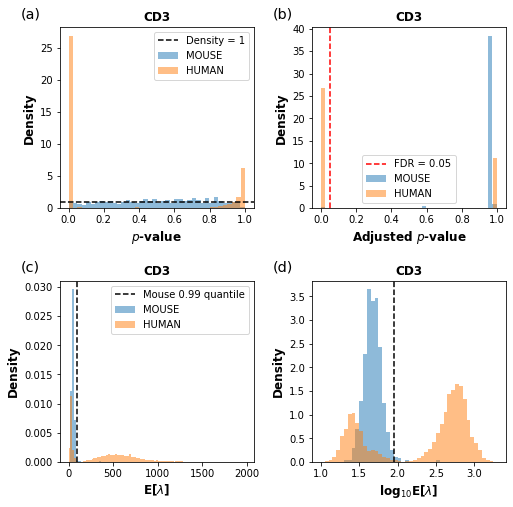

In [5]:
### generate figure from NB fitting
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(wspace=0.3, hspace=0.4)

fig.add_subplot(2,2,1)
plt.hist(pval0, bins=40, density=True, alpha = 0.5, label='MOUSE')
plt.hist(pval1, bins=40, density=True, alpha = 0.5, label='HUMAN')
plt.axhline(y=1., c='black', ls='--', label='Density = 1')
plt.xlabel('$\it{p}$-value', size='large', weight='bold')
plt.ylabel('Density', size='large', weight='bold')
plt.xlim([-0.05,1.05])
plt.legend()
plt.title(antigen, weight = 'bold')
plt.annotate('(a)', xy=(-0.2, 1.05), xycoords="axes fraction", size='x-large')

fig.add_subplot(2,2,2)
plt.hist(padj0, bins=40, density=True, alpha = 0.5, label='MOUSE')
plt.hist(padj1, bins=40, density=True, alpha = 0.5, label='HUMAN')
plt.axvline(x=0.05, c='red', ls='--', label='FDR = 0.05')

plt.xlabel('Adjusted $\it{p}$-value', size='large', weight='bold')
plt.ylabel('Density', size='large', weight='bold')
plt.xlim([-0.05,1.05])
plt.legend()
plt.title(antigen, weight = 'bold')
plt.annotate('(b)', xy=(-0.2, 1.05), xycoords="axes fraction", size='x-large')

fig.add_subplot(2,2,3)
ly0 = e_lam[df_ADT_label == 'MOUSE']
ly1 = e_lam[df_ADT_label != 'MOUSE']
binwidth = 20
hbins=np.arange(np.floor(ly1.min()/binwidth)*binwidth, np.ceil(ly1.max()/binwidth)*binwidth + binwidth, binwidth)
plt.hist(ly0, bins=hbins, density=True, alpha = 0.5, label='MOUSE')
plt.hist(ly1, bins=hbins, density=True, alpha = 0.5, label='HUMAN')
cutoff = np.quantile(ly0, 0.99)
plt.axvline(x=cutoff, c='black', ls='--', label='Mouse 0.99 quantile')
plt.xlabel('E[$\lambda$]', size='large', weight='bold')
plt.ylabel('Density', size='large', weight='bold')
plt.legend()
plt.title(antigen, weight = 'bold')
plt.annotate('(c)', xy=(-0.2, 1.05), xycoords="axes fraction", size='x-large')

fig.add_subplot(2,2,4)
ly0 = log_e_lam[df_ADT_label == 'MOUSE']
ly1 = log_e_lam[df_ADT_label != 'MOUSE']
binwidth = 0.05
hbins=np.arange(np.floor(ly1.min()/binwidth)*binwidth, np.ceil(ly1.max()/binwidth)*binwidth + binwidth, binwidth)
plt.hist(ly0, bins=hbins, density=True, alpha = 0.5, label='MOUSE')
plt.hist(ly1, bins=hbins, density=True, alpha = 0.5, label='HUMAN')
cutoff = np.quantile(ly0, 0.99)
plt.axvline(x=cutoff, c='black', ls='--', label='Mouse 0.99 quantile')
plt.xlabel('log${}_{10}$E[$\lambda$]', size='large', weight='bold')
plt.ylabel('Density', size='large', weight='bold')
plt.title(antigen, weight = 'bold')
plt.annotate('(d)', xy=(-0.2, 1.05), xycoords="axes fraction", size='x-large')

plt.show()
fig.savefig(path_figs+os.sep+'NB_fitting_'+'human_'+antigen+'.pdf', bbox_inches='tight')


## Mouse skin data set

In [6]:
path_data = os.path.join( '..', 'data')
path_csv = os.path.join( path_data, 'mouse_skin_ADT_raw_w_label_6samples.csv')
df_ADT_raw_w_label_6samples = pd.read_csv(path_csv, index_col=None)
df_ADT_label = df_ADT_raw_w_label_6samples['Species']
df_ADT_sample = df_ADT_raw_w_label_6samples['Sample']
df_ADT_raw = df_ADT_raw_w_label_6samples.drop(columns=['Species','Sample'])
n_cells = len(df_ADT_raw_w_label_6samples)
total_count = np.sum(df_ADT_raw, axis=1)
list_samples = np.unique(df_ADT_sample)
n_samples = len(list_samples)
list_antigens_all = np.asarray(df_ADT_raw.columns)
list_antigens_print = ['CD3', 'CD4', 'CD8a', 'CD69', 'CD62L', 'CD44', 'CD25', 'CD127',
       'TCR γ/δ', 'CD19', 'IgM', 'CD335', 'NK-1.1', 'CD90.2', 'I-A/I-E',
       'CD45R', 'CD11b', 'CD172a', 'XCR1', 'CD103', 'CD64', 'CD11c',
       'CD24', 'CD326', 'CD195', 'CD196', 'CXCR4', 'CD134', 'CD278',
       'CD223', 'CD274', 'KLRG1', 'CD27', 'CD21/CD35', 'CD86', 'IgD',
       'CD1d', 'CD138', 'CD117', 'CX3CR1', 'F4/80', 'CD192'] # not good in file name

path_outs = os.path.join( '..', 'output')
if not os.path.exists(path_outs):
    os.makedirs(path_outs)
path_figs = path_outs
# path_figs = os.path.join( path_outs, 'figs' )
# if not os.path.exists(path_figs):
#     os.makedirs(path_figs)

### Removing batch effects

In [7]:
list_samples_excluded = ['EtOH2', 'OXA2', 'OXA2']
list_samples_combined = ['EtOH1', 'EtOH3', 'OXA3']
for i in range(len(list_samples_combined)):
    df_ADT_SpikeIn_i = df_ADT_raw.loc[np.logical_and( df_ADT_label == 'HUMAN', df_ADT_sample == list_samples_combined[i] )]
    if i == 0:
        df_ADT_SpikeIn_combined = df_ADT_SpikeIn_i.copy()
    else:
        df_ADT_SpikeIn_combined = df_ADT_SpikeIn_combined.append(df_ADT_SpikeIn_i.copy())

consensus_CoM = count2shpere_CoM(df_ADT_SpikeIn_combined)

df_ADT_on_hsphere = df_ADT_raw_w_label_6samples.copy()
df_ADT_on_simplex = df_ADT_raw_w_label_6samples.copy()
df_ADT_on_hsphere_adj = df_ADT_raw_w_label_6samples.copy()
df_ADT_on_simplex_adj = df_ADT_raw_w_label_6samples.copy()

for i in range(len(list_samples)):
    df_ADT_SpikeIn_i = df_ADT_raw.loc[np.logical_and( df_ADT_label == 'HUMAN', df_ADT_sample == list_samples[i] )]
    CoM_i = count2shpere_CoM(df_ADT_SpikeIn_i)
    df_ADT_raw_i = df_ADT_raw.loc[ df_ADT_sample == list_samples[i] ]
    df_ADT_label_i = df_ADT_label.loc[ df_ADT_sample == list_samples[i] ]
    count_data = df_ADT_raw_i.copy()

    ADT_on_hsphere_i = count2shpere(count_data)
    ADT_on_simplex_i = sphere2simplex(ADT_on_hsphere_i)
    ADT_on_hsphere_adj_i = RotateData_s(ADT_on_hsphere_i, CoM_i, consensus_CoM)
    ADT_on_simplex_adj_i = sphere2simplex(ADT_on_hsphere_adj_i)

    df_ADT_on_hsphere.loc[df_ADT_sample == list_samples[i], list_antigens_all] = ADT_on_hsphere_i
    df_ADT_on_simplex.loc[df_ADT_sample == list_samples[i], list_antigens_all] = ADT_on_simplex_i
    df_ADT_on_hsphere_adj.loc[df_ADT_sample == list_samples[i], list_antigens_all] = ADT_on_hsphere_adj_i
    df_ADT_on_simplex_adj.loc[df_ADT_sample == list_samples[i], list_antigens_all] = ADT_on_simplex_adj_i

df_ADT_adj = pd.DataFrame( data=np.rint( df_ADT_on_simplex_adj[list_antigens_all] * total_count[:,None] ), dtype=int, columns=list_antigens_all)


### Example of NB fitting and statistical test

In [8]:
### calculate the relative size factors
lg = np.mean(np.log(df_ADT_adj+1.), axis=1)
lg0 = lg[df_ADT_label == 'HUMAN']
lg00 = np.mean(lg0)
m = np.exp(lg - lg00)
m0 = m[df_ADT_label == 'HUMAN']
m1 = m[df_ADT_label == 'MOUSE']

### choose an antigen
antigen = 'I-A-I-E'
y = df_ADT_adj[antigen]
y0 = y[df_ADT_label == 'HUMAN']
y1 = y[df_ADT_label == 'MOUSE']

(a, b) = em_nb(y0, m0)
pval0 = pval_nb(y0, m0, a, b)
pval1 = pval_nb(y1, m1, a, b)
padj0 = p_adjust_bh(pval0)
padj1 = p_adjust_bh(pval1)
e_lam = transf_zinb(y, m, a, b, w0=0., is_log='False')
log_e_lam = transf_zinb(y, m, a, b, w0=0., is_log='True', log_base=10)

a = 6.677922193630089 , b = 0.5604250988207039 , w = 0.0 , log: False
a = 6.677922193630089 , b = 0.5604250988207039 , w = 0.0 , log: True , base = 10


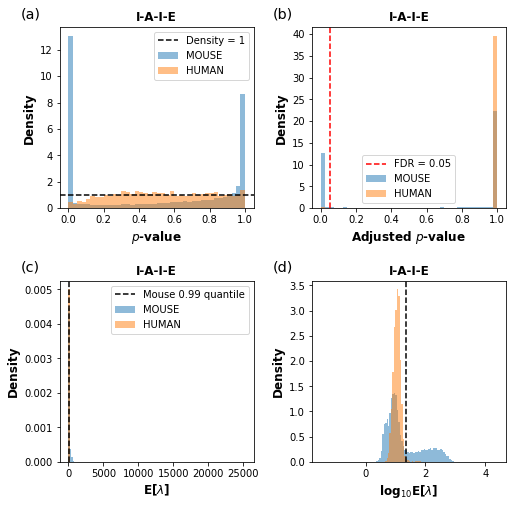

In [9]:
### generate figure from NB fitting
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(wspace=0.3, hspace=0.4)

fig.add_subplot(2,2,1)
plt.hist(pval1, bins=40, density=True, alpha = 0.5, label='MOUSE')
plt.hist(pval0, bins=40, density=True, alpha = 0.5, label='HUMAN')
plt.axhline(y=1., c='black', ls='--', label='Density = 1')
plt.xlabel('$\it{p}$-value', size='large', weight='bold')
plt.ylabel('Density', size='large', weight='bold')
plt.xlim([-0.05,1.05])
plt.legend()
plt.title(antigen, weight = 'bold')
plt.annotate('(a)', xy=(-0.2, 1.05), xycoords="axes fraction", size='x-large')

fig.add_subplot(2,2,2)
plt.hist(padj1, bins=40, density=True, alpha = 0.5, label='MOUSE')
plt.hist(padj0, bins=40, density=True, alpha = 0.5, label='HUMAN')
plt.axvline(x=0.05, c='red', ls='--', label='FDR = 0.05')

plt.xlabel('Adjusted $\it{p}$-value', size='large', weight='bold')
plt.ylabel('Density', size='large', weight='bold')
plt.xlim([-0.05,1.05])
plt.legend()
plt.title(antigen, weight = 'bold')
plt.annotate('(b)', xy=(-0.2, 1.05), xycoords="axes fraction", size='x-large')

fig.add_subplot(2,2,3)
ly1 = e_lam[df_ADT_label == 'MOUSE']
ly0 = e_lam[df_ADT_label == 'HUMAN']
binwidth = 200
hbins=np.arange(np.floor(ly1.min()/binwidth)*binwidth, np.ceil(ly1.max()/binwidth)*binwidth + binwidth, binwidth)
plt.hist(ly1, bins=hbins, density=True, alpha = 0.5, label='MOUSE')
plt.hist(ly0, bins=hbins, density=True, alpha = 0.5, label='HUMAN')
cutoff = np.quantile(ly0, 0.99)
plt.axvline(x=cutoff, c='black', ls='--', label='Mouse 0.99 quantile')
plt.xlabel('E[$\lambda$]', size='large', weight='bold')
plt.ylabel('Density', size='large', weight='bold')
plt.legend()
plt.title(antigen, weight = 'bold')
plt.annotate('(c)', xy=(-0.2, 1.05), xycoords="axes fraction", size='x-large')

fig.add_subplot(2,2,4)
ly1 = log_e_lam[df_ADT_label == 'MOUSE']
ly0 = log_e_lam[df_ADT_label != 'MOUSE']
binwidth = 0.05
hbins=np.arange(np.floor(ly1.min()/binwidth)*binwidth, np.ceil(ly1.max()/binwidth)*binwidth + binwidth, binwidth)
plt.hist(ly1, bins=hbins, density=True, alpha = 0.5, label='MOUSE')
plt.hist(ly0, bins=hbins, density=True, alpha = 0.5, label='HUMAN')
cutoff = np.quantile(ly0, 0.99)
plt.axvline(x=cutoff, c='black', ls='--', label='Mouse 0.99 quantile')
plt.xlabel('log${}_{10}$E[$\lambda$]', size='large', weight='bold')
plt.ylabel('Density', size='large', weight='bold')
plt.title(antigen, weight = 'bold')
plt.annotate('(d)', xy=(-0.2, 1.05), xycoords="axes fraction", size='x-large')

plt.show()
fig.savefig(path_figs+os.sep+'NB_fitting_'+'mouse_'+antigen+'.pdf', bbox_inches='tight')


### Example of ZINB fitting and statistical test

In [10]:
### calculate the relative size factors
lg = np.mean(np.log(df_ADT_adj+1.), axis=1)
lg0 = lg[df_ADT_label == 'HUMAN']
lg00 = np.mean(lg0)
m = np.exp(lg - lg00)
m0 = m[df_ADT_label == 'HUMAN']
m1 = m[df_ADT_label == 'MOUSE']

### choose an antigen
antigen = 'CD4'
y = df_ADT_adj[antigen]
y0 = y[df_ADT_label == 'HUMAN']
y1 = y[df_ADT_label == 'MOUSE']

(w0, a, b, is_conv) = em_zinb(y0, m0)
pval0 = pval_zinb(y0, m0, w0, a, b)
pval1 = pval_zinb(y1, m1, w0, a, b)
padj0 = p_adjust_bh(pval0)
padj1 = p_adjust_bh(pval1)
e_lam = transf_zinb(y, m, a, b, w0, is_log='False')
log_e_lam = transf_zinb(y, m, a, b, w0, is_log='True', log_base=10)

a = 9.042261478549769 , b = 5.7241479103582495 , w = 0.1398827945727591 , log: False
a = 9.042261478549769 , b = 5.7241479103582495 , w = 0.1398827945727591 , log: True , base = 10


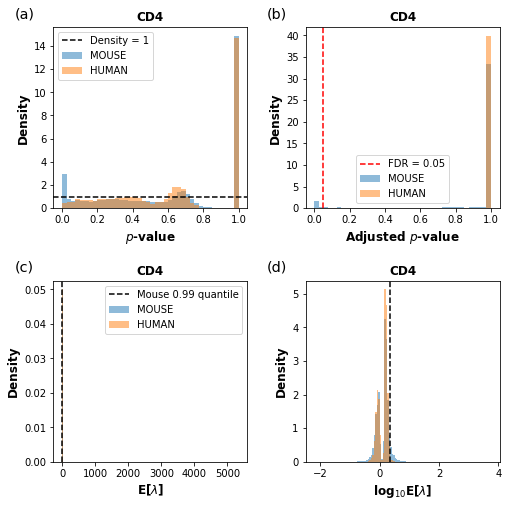

In [11]:
### generate figure from ZINB fitting
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(wspace=0.3, hspace=0.4)

fig.add_subplot(2,2,1)
plt.hist(pval1, bins=40, density=True, alpha = 0.5, label='MOUSE')
plt.hist(pval0, bins=40, density=True, alpha = 0.5, label='HUMAN')
plt.axhline(y=1., c='black', ls='--', label='Density = 1')
plt.xlabel('$\it{p}$-value', size='large', weight='bold')
plt.ylabel('Density', size='large', weight='bold')
plt.xlim([-0.05,1.05])
plt.legend()
plt.title(antigen, weight = 'bold')
plt.annotate('(a)', xy=(-0.2, 1.05), xycoords="axes fraction", size='x-large')

fig.add_subplot(2,2,2)
plt.hist(padj1, bins=40, density=True, alpha = 0.5, label='MOUSE')
plt.hist(padj0, bins=40, density=True, alpha = 0.5, label='HUMAN')
plt.axvline(x=0.05, c='red', ls='--', label='FDR = 0.05')

plt.xlabel('Adjusted $\it{p}$-value', size='large', weight='bold')
plt.ylabel('Density', size='large', weight='bold')
plt.xlim([-0.05,1.05])
plt.legend()
plt.title(antigen, weight = 'bold')
plt.annotate('(b)', xy=(-0.2, 1.05), xycoords="axes fraction", size='x-large')

fig.add_subplot(2,2,3)
ly1 = e_lam[df_ADT_label == 'MOUSE']
ly0 = e_lam[df_ADT_label == 'HUMAN']
binwidth = 20
hbins=np.arange(np.floor(ly1.min()/binwidth)*binwidth, np.ceil(ly1.max()/binwidth)*binwidth + binwidth, binwidth)
plt.hist(ly1, bins=hbins, density=True, alpha = 0.5, label='MOUSE')
plt.hist(ly0, bins=hbins, density=True, alpha = 0.5, label='HUMAN')
cutoff = np.quantile(ly0, 0.99)
plt.axvline(x=cutoff, c='black', ls='--', label='Mouse 0.99 quantile')
plt.xlabel('E[$\lambda$]', size='large', weight='bold')
plt.ylabel('Density', size='large', weight='bold')
plt.legend()
plt.title(antigen, weight = 'bold')
plt.annotate('(c)', xy=(-0.2, 1.05), xycoords="axes fraction", size='x-large')

fig.add_subplot(2,2,4)
ly1 = log_e_lam[df_ADT_label == 'MOUSE']
ly0 = log_e_lam[df_ADT_label != 'MOUSE']
binwidth = 0.05
hbins=np.arange(np.floor(ly1.min()/binwidth)*binwidth, np.ceil(ly1.max()/binwidth)*binwidth + binwidth, binwidth)
plt.hist(ly1, bins=hbins, density=True, alpha = 0.5, label='MOUSE')
plt.hist(ly0, bins=hbins, density=True, alpha = 0.5, label='HUMAN')
cutoff = np.quantile(ly0, 0.99)
plt.axvline(x=cutoff, c='black', ls='--', label='Mouse 0.99 quantile')
plt.xlabel('log${}_{10}$E[$\lambda$]', size='large', weight='bold')
plt.ylabel('Density', size='large', weight='bold')
plt.title(antigen, weight = 'bold')
plt.annotate('(d)', xy=(-0.2, 1.05), xycoords="axes fraction", size='x-large')

plt.show()
fig.savefig(path_figs+os.sep+'ZINB_fitting_'+'mouse_'+antigen+'.pdf', bbox_inches='tight')
